# 任务二 RNN-LSTM图像分类

每一笔画的数据总共5维；
每个图像最多139/62……划；
每个数据集有70000张图像


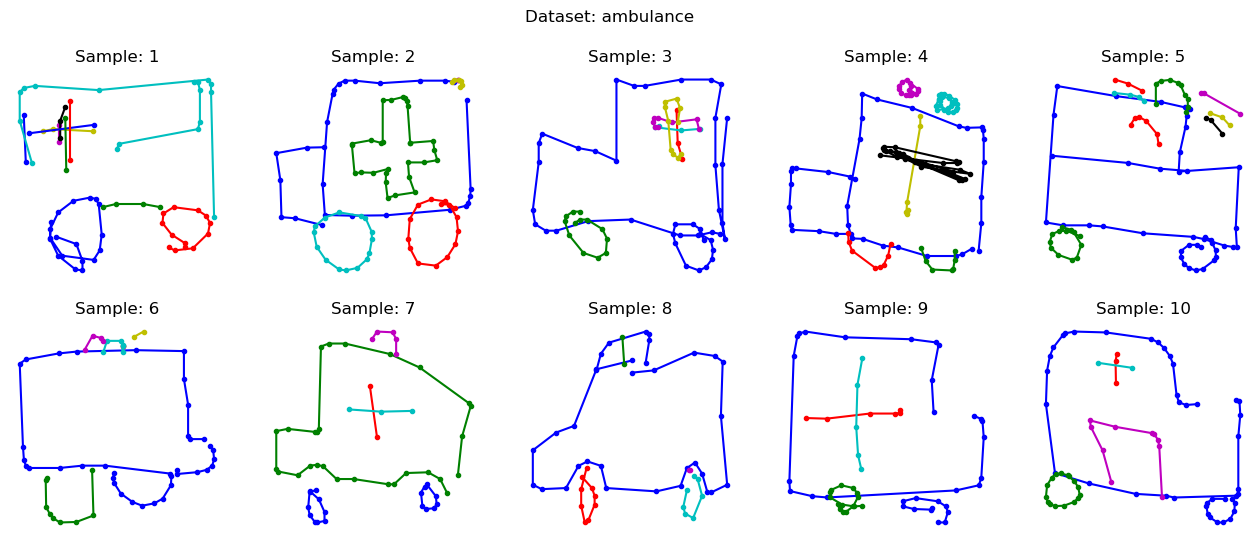

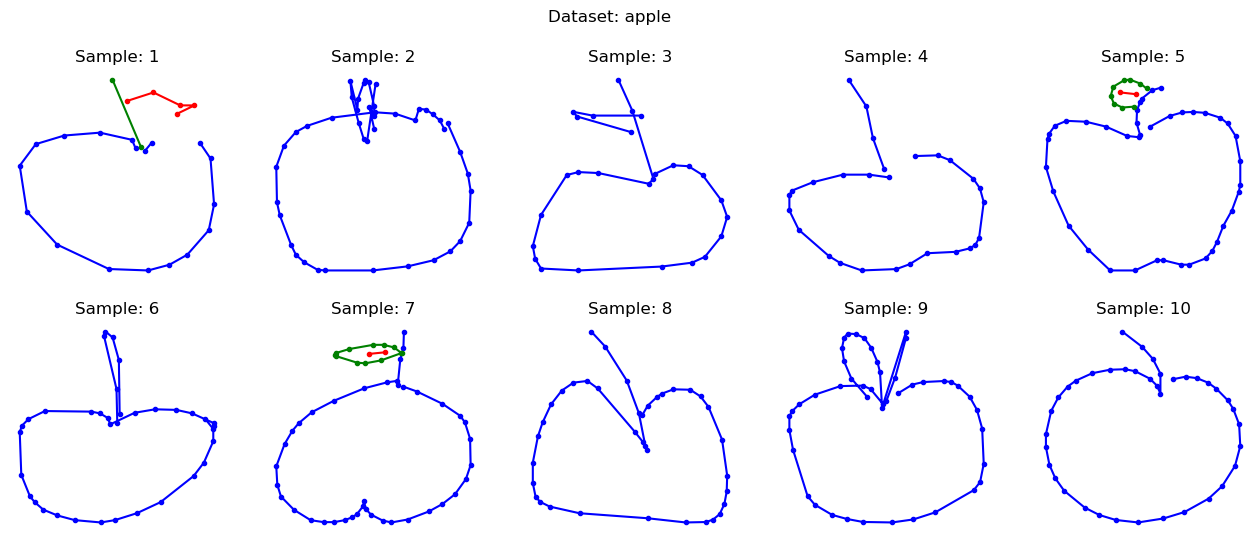

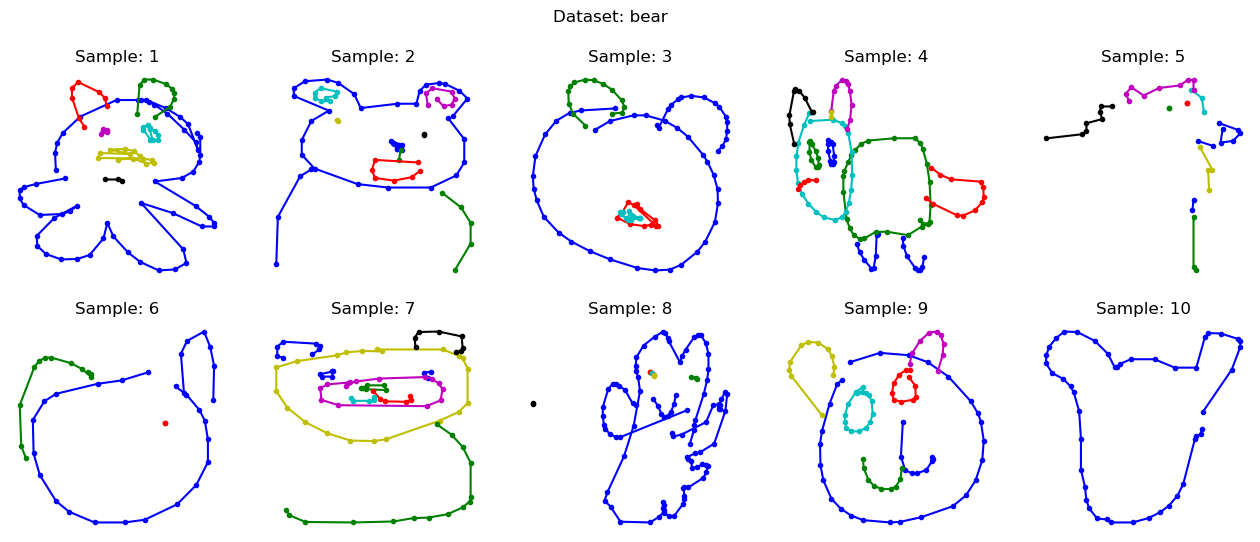

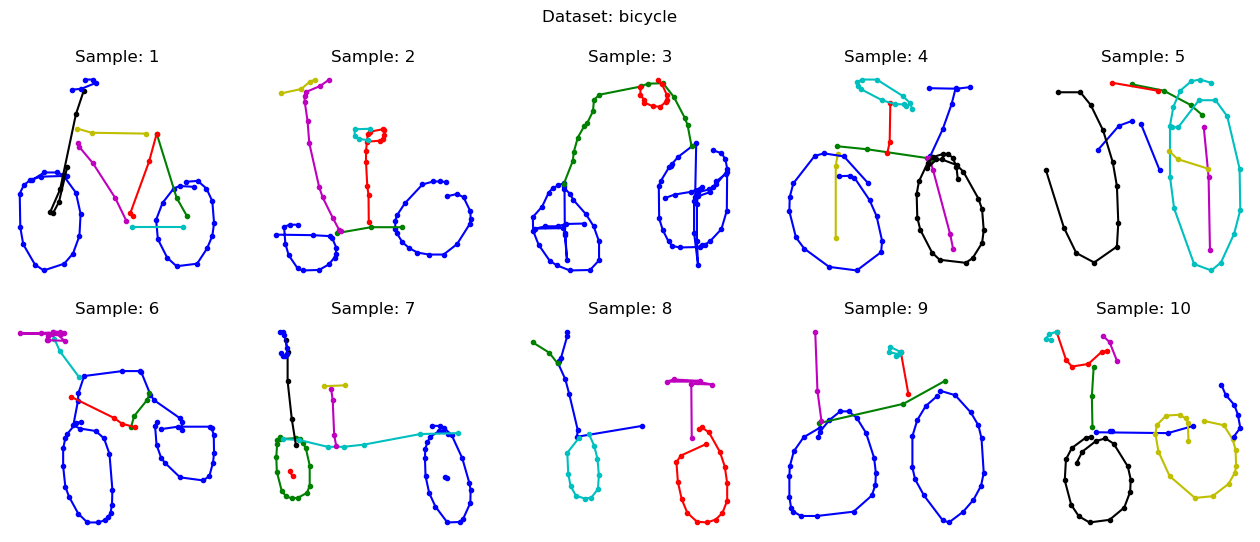

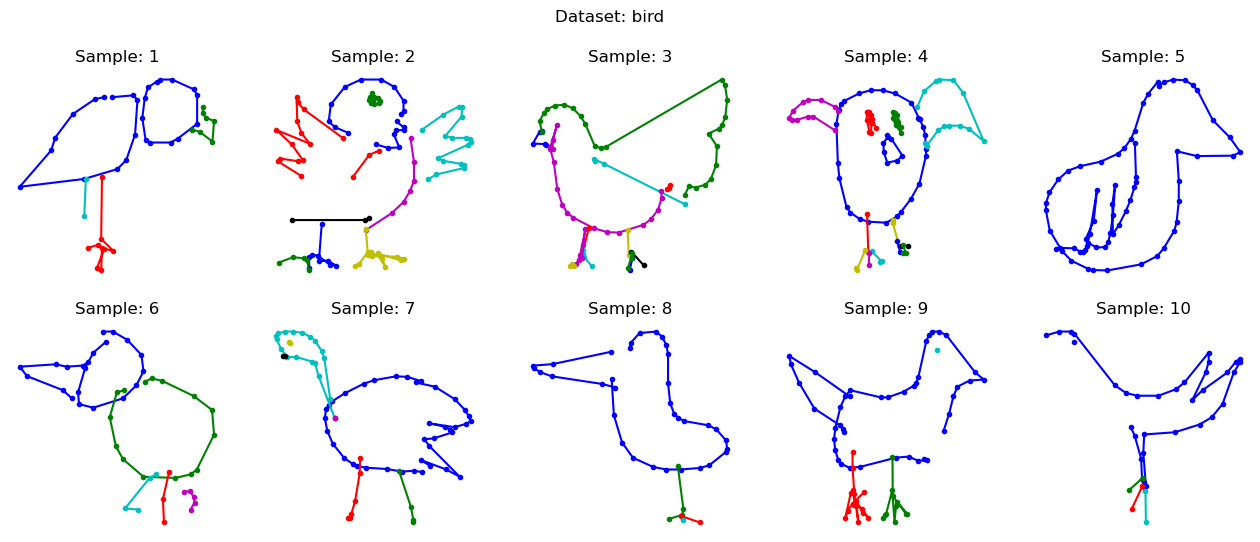

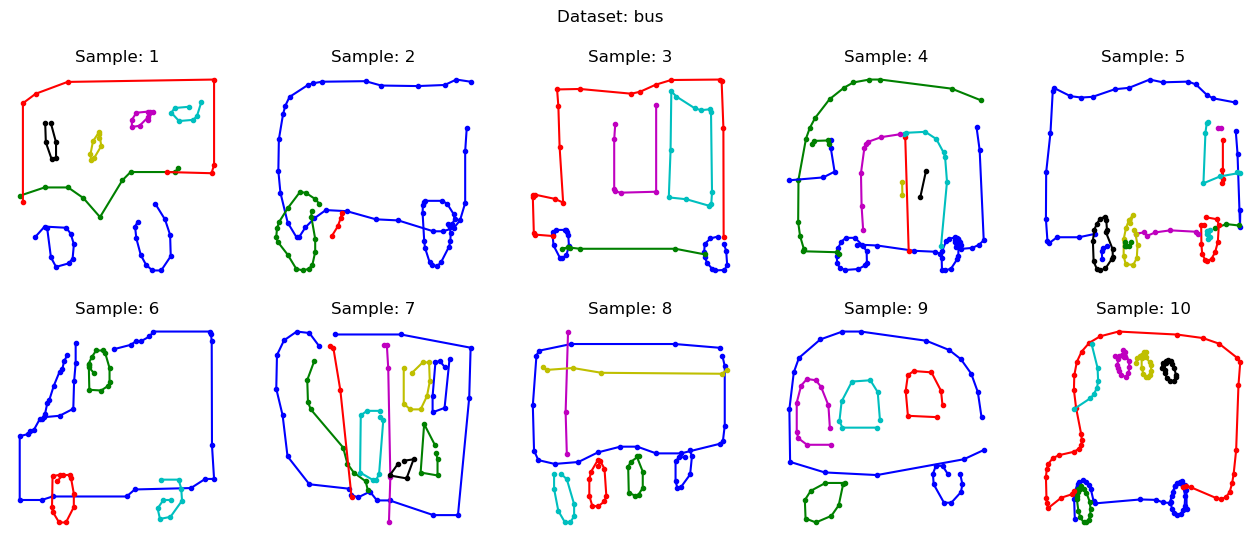

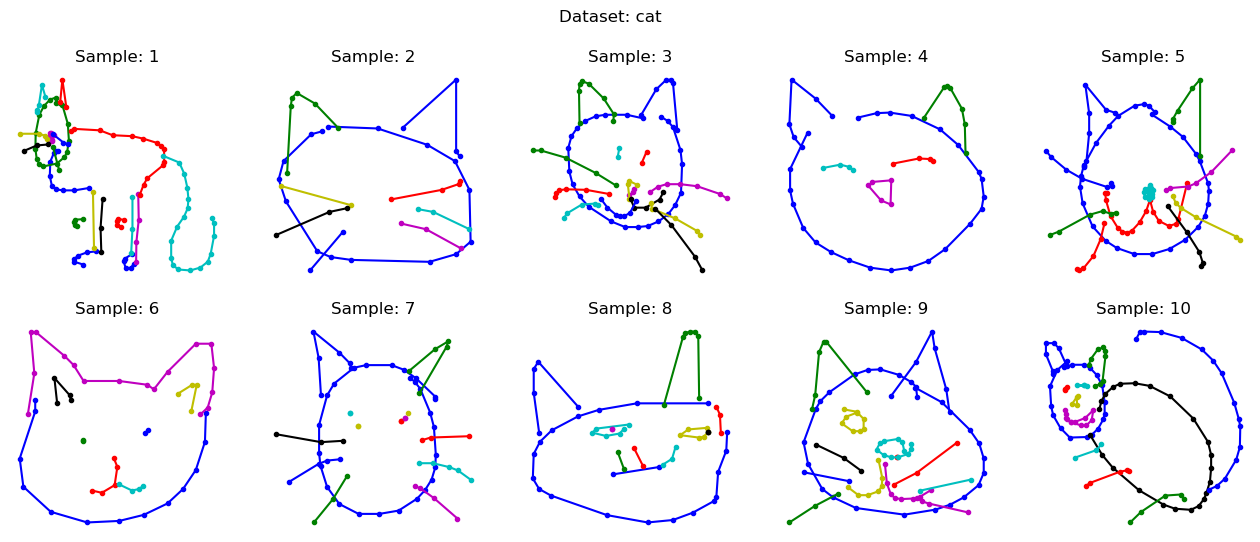

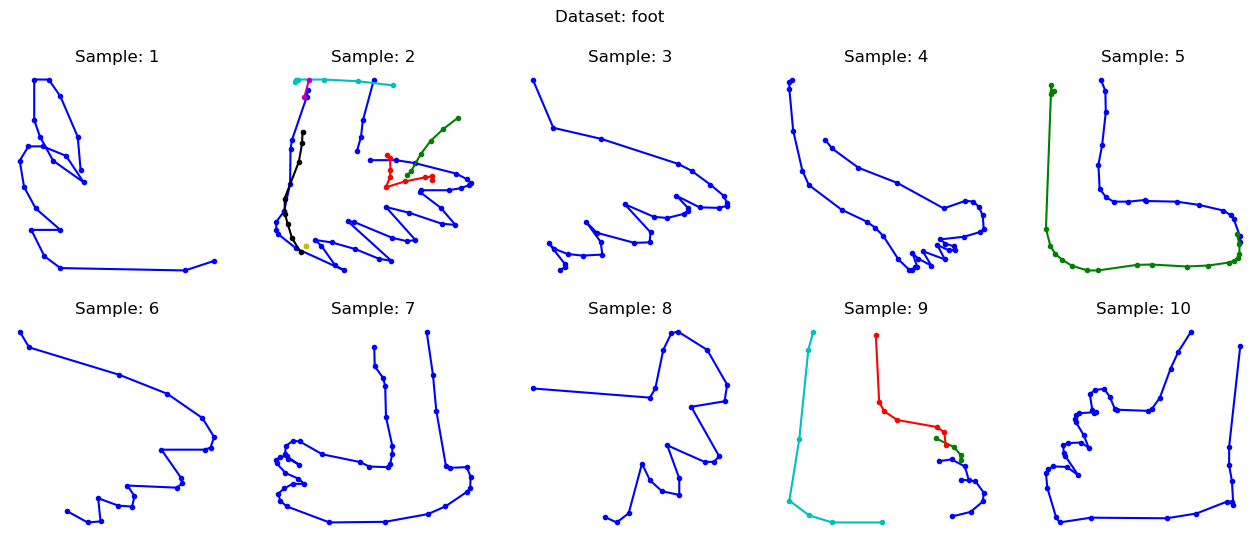

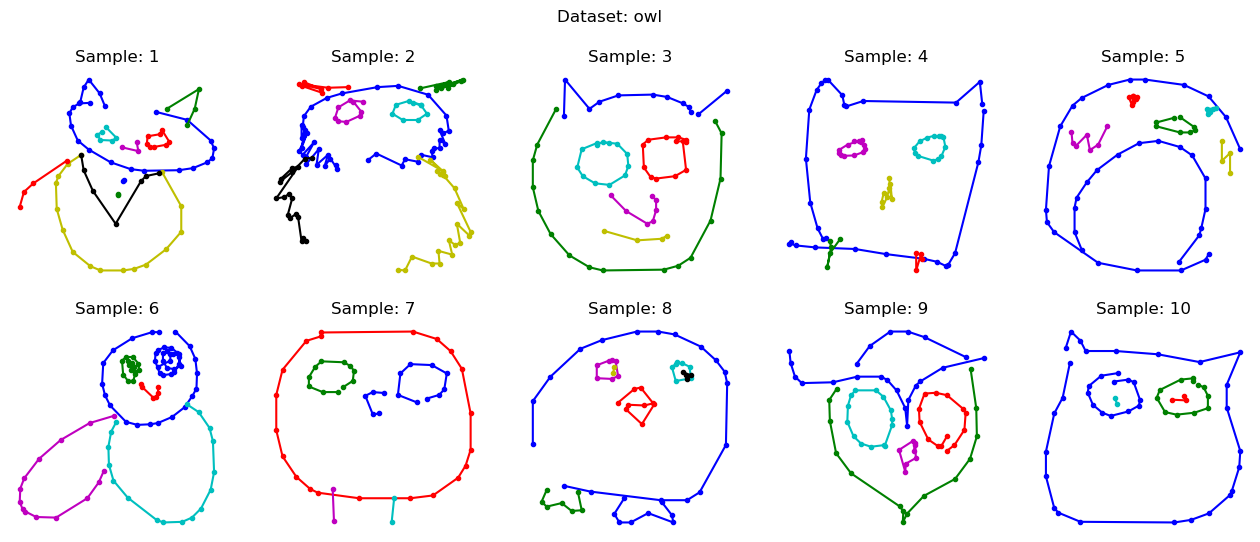

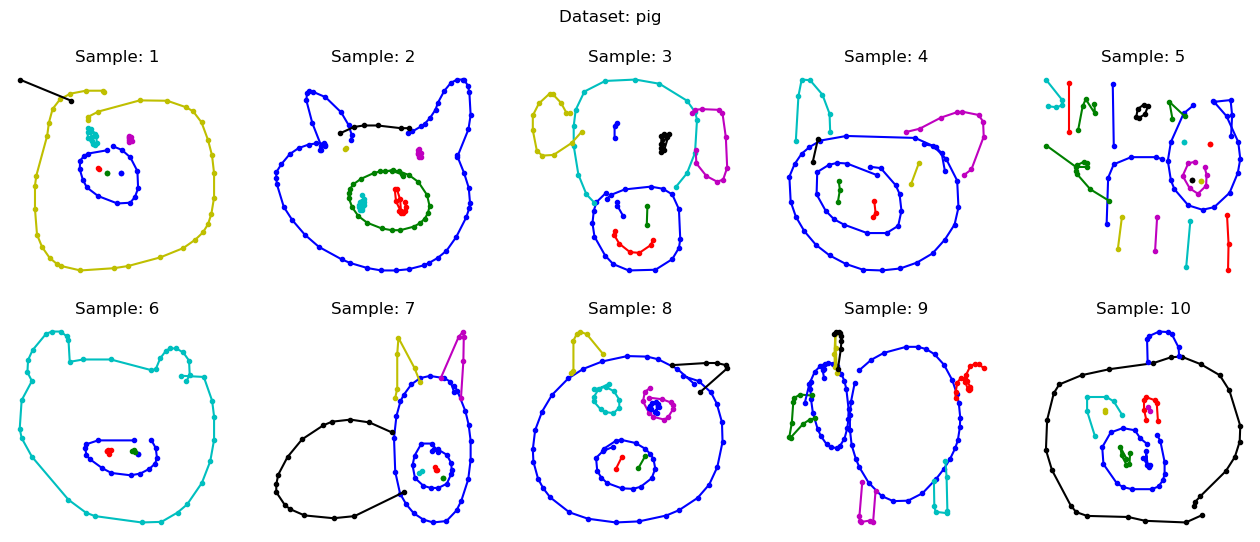

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 标签定义
# ‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’,‘foot’,‘owl’,‘pig‘
labels = {'ambulance':0, 'apple':1, 'bear':2, 'bicycle':3, 'bird':4, 'bus':5, 'cat':6, 'foot':7, 'owl':8, 'pig':9}

# 路径
file_path = './2023-GAI-实验4-手绘图点序列数据集/sketch_datas'

def read_and_show_data(path, dataset_name, show_num):
    file = np.load(path + '/' + dataset_name + '.npy')
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']    # 创建一个颜色列表，用于标识不同的点序列
    # 从数组中随机抽取元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  


    # 绘图
    plt.figure(figsize=(16, 6))
    for i in range(show_num):
        plt.subplot(2, 5, i+1) 
        image_data = random_samples[i]

        axis = np.cumsum(image_data[:,:2], axis=0)
        track = []
        color_index = 0
        color = colors[0]

        # 具体绘图
        for j in range(axis.shape[0]):
            track.append([-axis[j][0], -axis[j][1]])

            if image_data[j][4] == 1.: # 绘画结束
                plt.plot(*zip(*track), marker='.', color=color)
                track = []
                break

            if image_data[j][3] == 1.: # 画笔抬起
                plt.plot(*zip(*track), marker='.', color=color)
                track = []
                color = colors[(color_index)%len(colors)]
                color_index += 1

        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    # # 每张图片数据reshape
    # data = []
    # for pic in file:
    #     data.append(pic.reshape(1,28,28)) # channel，height，width
    

    # return np.array(data) # 使用np数组



read_and_show_data(file_path, 'ambulance', 10) 
read_and_show_data(file_path, 'apple', 10)
read_and_show_data(file_path, 'bear', 10)
read_and_show_data(file_path, 'bicycle', 10)
read_and_show_data(file_path, 'bird', 10)
read_and_show_data(file_path, 'bus', 10)
read_and_show_data(file_path, 'cat', 10)
read_and_show_data(file_path, 'foot', 10)
read_and_show_data(file_path, 'owl', 10)
read_and_show_data(file_path, 'pig', 10)
